In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`02_current_injection.ipynb`**. See the button at the top right to download as markdown or pdf.
:::

# Introduction to GLM and NeMoS

For our first example, we will look at a very simple dataset: patch-clamp
recordings from a single neuron in layer 4 of mouse primary visual cortex. This
data is from the [Allen Brain
Atlas](https://celltypes.brain-map.org/experiment/electrophysiology/478498617),
and experimenters injected current directly into the cell, while recording the
neuron's membrane potential and spiking behavior. The experiments varied the
shape of the current across many sweeps, mapping the neuron's behavior in
response to a wide range of potential inputs.

For our purposes, we will examine only one of these sweeps, "Noise 1", in which
the experimentalists injected three pulses of current. The current is a square
pulse multiplied by a sinusoid of a fixed frequency, with some random noise
riding on top.

<div class="render-user render-presenter">
Data for this notebook is a patch clamp experiment with a mouse V1 neuron, from the [Allen Brain Atlas](https://celltypes.brain-map.org/experiment/electrophysiology/478498617)
</div>

<div class="render-all">

![Allen Brain Atlas view of the data we will analyze.](../../_static/allen_data.png)

</div>

In the figure above (from the Allen Brain Atlas website), we see the
approximately 22 second sweep, with the input current plotted in the first row,
the intracellular voltage in the second, and the recorded spikes in the third.
(The grey lines and dots in the second and third rows comes from other sweeps
with the same stimulus, which we'll ignore in this exercise.) When fitting the
Generalized Linear Model, we are attempting to model the spiking behavior, and
we generally do not have access to the intracellular voltage, so for the rest
of this notebook, we'll use only the input current and the recorded spikes
displayed in the first and third rows.

First, let us see how to load in the data and reproduce the above figure, which
we'll do using [pynapple](https://pynapple.org). This will largely be a
review of what we went through yesterday. After we've explored the data some, we'll
introduce the Generalized Linear Model and how to fit it with NeMoS.

<div class="render-all">

## Learning objectives 

- Learn how to explore spiking data and do basic analyses using pynapple
- Learn how to structure data for NeMoS
- Learn how to fit a basic Generalized Linear Model using NeMoS
- Learn how to retrieve the parameters and predictions from a fit GLM for
  intrepetation.
</div>

In [2]:
import workshop_utils
# Import everything
import jax
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

import nemos as nmo

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

# some helper plotting functions
from nemos import _documentation_utils as doc_plots

# configure plots some
plt.style.use(nmo.styles.plot_style)

## Data Streaming

While you can download the data directly from the Allen Brain Atlas and
interact with it using their
[AllenSDK](https://allensdk.readthedocs.io/en/latest/visual_behavior_neuropixels.html),
we prefer the burgeoning [Neurodata Without Borders (NWB)
standard](https://nwb-overview.readthedocs.io/en/latest/). We have converted
this single dataset to NWB and uploaded it to the [Open Science
Framework](https://osf.io/5crqj/). This allows us to easily load the data
using pynapple, and it will immediately be in a format that pynapple understands!

:::{tip}

  Pynapple can stream any NWB-formatted dataset! See [their
  documentation](https://pynapple.org/examples/tutorial_pynapple_dandi.html)
  for more details, and see the [DANDI Archive](https://dandiarchive.org/)
  for a repository of compliant datasets.
:::

The first time the following cell is run, it will take a little bit of time
to download the data, and a progress bar will show the download's progress.
On subsequent runs, the cell gets skipped: we do not need to redownload the
data.

<div class="render-user render-presenter">
- Stream the data. Format is [Neurodata Without Borders (NWB) standard](https://nwb-overview.readthedocs.io/en/latest/)
</div>

In [3]:
path = workshop_utils.fetch_data("allen_478498617.nwb")

## Pynapple

### Data structures and preparation

Now that we've downloaded the data, let's open it with pynapple and examine
its contents.

<div class="render-user render-presenter">
- Open the NWB file with [pynapple](https://pynapple.org)
</div>

In [4]:
data = nap.load_file(path)
print(data)

allen_478498617
┍━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys     │ Type        │
┝━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units    │ TsGroup     │
│ epochs   │ IntervalSet │
│ stimulus │ Tsd         │
│ response │ Tsd         │
┕━━━━━━━━━━┷━━━━━━━━━━━━━┙


The dataset contains several different pynapple objects, which we will
explore throughout this demo. The following illustrates how these fields relate to the data
we visualized above:

<div class="render-all">

![Annotated view of the data we will analyze.](../../_static/allen_data_annotated.gif)
<!-- this gif created with the following imagemagick command: convert -layers OptimizePlus -delay 100 allen_data_annotated-units.svg allen_data_annotated-epochs.svg allen_data_annotated-stimulus.svg allen_data_annotated-response.svg -loop 0 allen_data_annotated.gif -->

- `stimulus`: injected current, in Amperes, sampled at 20k Hz.
- `response`: the neuron's intracellular voltage, sampled at 20k Hz. We will not use this info in this example.
- `units`: dictionary of neurons, holding each neuron's spike timestamps.
- `epochs`: start and end times of different intervals, defining the experimental structure, specifying when each stimulation protocol began and ended.
</div>

Now let's go through the relevant variables in some more detail:

In [5]:
trial_interval_set = data["epochs"]

current = data["stimulus"]
spikes = data["units"]

First, let's examine `trial_interval_set`:

In [6]:
trial_interval_set

index    start    end      tags
0        0.0      34.02    Ramp
1        39.02    73.04    Ramp
2        78.04    112.06   Ramp
3        117.06   119.083  Short Square
4        124.083  126.106  Short Square
5        131.106  133.129  Short Square
6        138.129  140.152  Short Square
...      ...      ...      ...
60       841.387  845.056  Short Square - Triple
61       850.056  853.725  Short Square - Triple
62       858.725  862.394  Short Square - Triple
63       867.394  871.063  Short Square - Triple
64       876.063  879.732  Short Square - Triple
65       884.732  888.401  Short Square - Triple
66       893.401  897.421  Test
shape: (67, 2), time unit: sec.

`trial_interval_set` is an
[`IntervalSet`](https://pynapple.org/generated/pynapple.IntervalSet.html),
with a metadata columns (`tags`) defining the stimulus protocol.

<div class="render-user render-presenter">"
- `Noise 1`: epochs of random noise
</div>

In [7]:
noise_interval = trial_interval_set[trial_interval_set.tags == "Noise 1"]
noise_interval

  index    start      end  tags
      0  460.768  488.788  Noise 1
      1  526.808  554.828  Noise 1
      2  592.848  620.868  Noise 1
shape: (3, 2), time unit: sec.

As described above, we will be examining "Noise 1". We can see it contains
three rows, each defining a separate sweep. We'll just grab the first sweep
(shown in blue in the pictures above) and ignore the other two (shown in
gray).

<div class="render-user render-presenter">"
- Let's focus on the first epoch.
</div>

In [8]:
noise_interval = noise_interval[0]
noise_interval

  index    start      end  tags
      0  460.768  488.788  Noise 1
shape: (1, 2), time unit: sec.

Now let's examine `current`:

<div class="render-user render-presenter">"
- `current` : Tsd (TimeSeriesData) : time index + data
</div>

In [9]:
current

Time (s)
-------------  --
0.0             0
5e-05           0
0.0001          0
0.00015         0
0.0002          0
0.00025         0
0.0003          0
...
897.420649999   0
897.420699999   0
897.420749999   0
897.420799999   0
897.420849999   0
897.420899999   0
897.420949999   0
dtype: float64, shape: (11348420,)

`current` is a `Tsd`
([TimeSeriesData](https://pynapple.org/generated/pynapple.Tsd.html))
object with 2 columns. Like all `Tsd` objects, the first column contains the
time index and the second column contains the data; in this case, the current
in Ampere (A).

Currently, `current` contains the entire ~900 second experiment but, as
discussed above, we only want one of the "Noise 1" sweeps. Fortunately,
`pynapple` makes it easy to grab out the relevant time points by making use
of the `noise_interval` we defined above:

<div class="render-user render-presenter">"
- `restrict` : restricts a time series object to a set of time intervals delimited by an IntervalSet object
</div>

In [10]:
current = current.restrict(noise_interval)
# convert current from Ampere to pico-amperes, to match the above visualization
# and move the values to a more reasonable range.
current = current * 1e12
current

Time (s)
-------------  --
460.768         0
460.76805       0
460.7681        0
460.76815       0
460.7682        0
460.76825       0
460.7683        0
...
488.787649993   0
488.787699993   0
488.787749993   0
488.787799993   0
488.787849993   0
488.787899993   0
488.787949993   0
dtype: float64, shape: (560400,)

Notice that the timestamps have changed and our shape is much smaller.

Finally, let's examine the spike times. `spikes` is a
[`TsGroup`](https://pynapple.org/generated/pynapple.TsGroup.html),
a dictionary-like object that holds multiple `Ts` (timeseries) objects with
potentially different time indices:

<div class="render-user render-presenter">"
- `TsGroup` : a dictionary-like object holding multiple `Ts` (timeseries) objects with potentially different time indices.
</div>

In [11]:
spikes

  Index     rate  location      group
-------  -------  ----------  -------
      0  0.87805  v1                0

Typically, this is used to hold onto the spike times for a population of
neurons. In this experiment, we only have recordings from a single neuron, so
there's only one row.

We can index into the `TsGroup` to see the timestamps for this neuron's
spikes:

<div class="render-user render-presenter">"
We can index into the `TsGroup` to see the timestamps for this neuron's spikes:
</div>

In [12]:
spikes[0]

Time (s)
1.85082
2.06869
2.20292
2.325815
2.42342
2.521415
2.604795
...
869.461695
878.08481
878.09765
878.110865
886.75375
886.761465
886.76995
shape: 777

Similar to `current`, this object originally contains data from the entire
experiment. To get only the data we need, we again use
`restrict(noise_interval)`:

<div class="render-user render-presenter">"
Let's restrict to the same epoch `noise_interval`:
</div>

In [13]:
spikes = spikes.restrict(noise_interval)
print(spikes)
spikes[0]

  Index     rate  location      group
-------  -------  ----------  -------
      0  1.42755  v1                0


Time (s)
470.81754
470.85842
470.907235
470.954925
471.0074
471.107175
471.25083
...
480.67927
480.81817
480.90529
480.94921
481.002715
481.60008
481.67727
shape: 40

Now, let's visualize the data from this trial, replicating rows 1 and 3
from the Allen Brain Atlas figure at the beginning of this notebook:

<div class="render-user render-presenter">"
Let's visualize the data from this trial:
</div>

Text(0.5, 0, 'Time (s)')

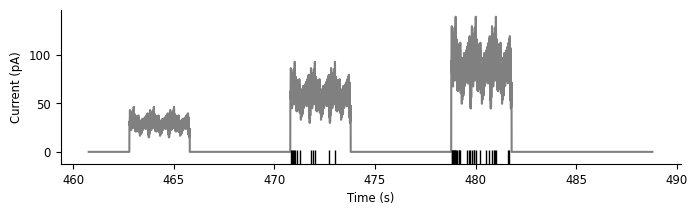

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(current, "grey")
ax.plot(spikes.to_tsd([-5]), "|", color="k", ms = 10)
ax.set_ylabel("Current (pA)")
ax.set_xlabel("Time (s)")

(current-inj-basic-full)=
### Basic analyses

Before using the Generalized Linear Model, or any model, it's worth taking
some time to examine our data and think about what features are interesting
and worth capturing. As Edoardo explained earlier today,
the GLM is a model of the neuronal firing rate. However, in our experiments,
we do not observe the firing rate, only the spikes! Moreover, neural
responses are typically noisy&mdash;even in this highly controlled experiment
where the same current was injected over multiple trials, the spike times
were slightly different from trial-to-trial. No model can perfectly predict
spike times on an individual trial, so how do we tell if our model is doing a
good job?

Our objective function is the log-likelihood of the observed spikes given the
predicted firing rate. That is, we're trying to find the firing rate, as a
function of time, for which the observed spikes are likely. Intuitively, this
makes sense: the firing rate should be high where there are many spikes, and
vice versa. However, it can be difficult to figure out if your model is doing
a good job by squinting at the observed spikes and the predicted firing rates
plotted together.

One common way to visualize a rough estimate of firing rate is to smooth
the spikes by convolving them with a Gaussian filter.

:::{note}

This is a heuristic for getting the firing rate, and shouldn't be taken
as the literal truth (to see why, pass a firing rate through a Poisson
process to generate spikes and then smooth the output to approximate the
generating firing rate). A model should not be expected to match this
approximate firing rate exactly, but visualizing the two firing rates
together can help you reason about which phenomena in your data the model
is able to adequately capture, and which it is missing.

For more information, see section 1.2 of [*Theoretical
Neuroscience*](https://boulderschool.yale.edu/sites/default/files/files/DayanAbbott.pdf),
by Dayan and Abbott.
:::

Pynapple can easily compute this approximate firing rate, and plotting this
information will help us pull out some phenomena that we think are
interesting and would like a model to capture.

First, we must convert from our spike times to binned spikes:

<div class="render-user render-presenter">"
The Generalized Linear Model gives a predicted firing rate. First we can use pynapple to visualize this firing rate for a single trial.

- `count` : count the number of events within `bin_size`
</div>

In [15]:
# bin size in seconds
bin_size = 0.001
# Get spikes for neuron 0
count = spikes[0].count(bin_size)
count

Time (s)
----------  --
460.7685     0
460.7695     0
460.7705     0
460.7715     0
460.7725     0
460.7735     0
460.7745     0
...
488.7815     0
488.7825     0
488.7835     0
488.7845     0
488.7855     0
488.7865     0
488.7875     0
dtype: int64, shape: (28020,)

Now, let's convert the binned spikes into the firing rate, by smoothing them
with a gaussian kernel. Pynapple again provides a convenience function for
this:

<div class="render-user render-presenter">"
Let's convert the spike counts to firing rate :

- `smooth` : convolve with a Gaussian kernel
</div>

In [16]:
# the inputs to this function are the standard deviation of the gaussian in seconds and
# the full width of the window, in standard deviations. So std=.05 and size_factor=20
# gives a total filter size of 0.05 sec * 20 = 1 sec.
firing_rate = count.smooth(std=0.05, size_factor=20)
# convert from spikes per bin to spikes per second (Hz)
firing_rate = firing_rate / bin_size

Note that firing_rate is a [`Tsd`](https://pynapple.org/generated/pynapple.Tsd.html)!

In [17]:
print(type(firing_rate))

<class 'pynapple.core.time_series.Tsd'>


Now that we've done all this preparation, let's make a plot to more easily
visualize the data.

:::{note}

We're hiding the details of the plotting function for the purposes of this tutorial, but you can find it in [the source
code](https://github.com/flatironinstitute/nemos/blob/development/src/nemos/_documentation_utils/plotting.py)
if you are interested.
:::

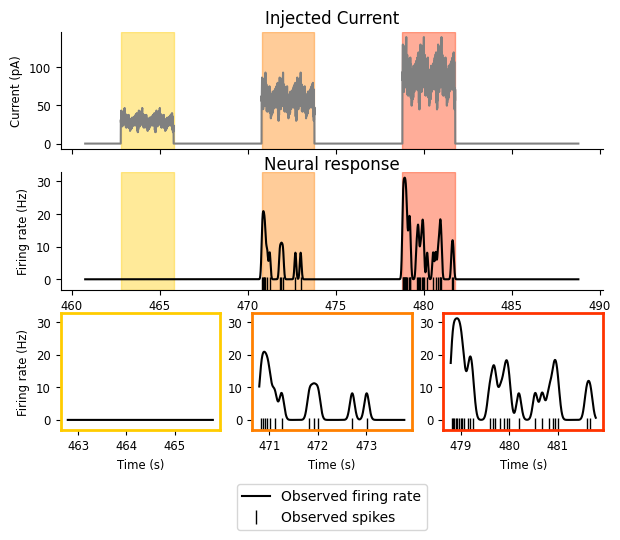

In [18]:
doc_plots.current_injection_plot(current, spikes, firing_rate);

So now that we can view the details of our experiment a little more clearly,
what do we see?

- We have three intervals of increasing current, and the firing rate
  increases as the current does.

- While the neuron is receiving the input, it does not fire continuously or
  at a steady rate; there appears to be some periodicity in the response. The
  neuron fires for a while, stops, and then starts again. There's periodicity
  in the input as well, so this pattern in the response might be reflecting
  that.

- There's some decay in firing rate as the input remains on: there are three or
  four "bumps" of neuronal firing in the second and third intervals and they
  decrease in amplitude, with the first being the largest.

These give us some good phenomena to try and predict! But there's something
that's not quite obvious from the above plot: what is the relationship
between the input and the firing rate? As described in the first bullet point
above, it looks to be *monotonically increasing*: as the current increases,
so does the firing rate. But is that exactly true? What form is that
relationship?

Pynapple can compute a tuning curve to help us answer this question, by
binning our spikes based on the instantaneous input current and computing the
firing rate within those bins:

:::{admonition} Tuning curve in `pynapple`
:class: note 

[`compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves) : compute the firing rate as a function of some feature(s).
:::

<div class="render-user render-presenter">"
What is the relationship between the current and the spiking activity?
[`compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves) : compute the firing rate as a function of some feature(s).
</div>

In [19]:
tuning_curve = nap.compute_tuning_curves(spikes, current, bins=15, feature_names=["current"])
tuning_curve

<xarray.DataArray (unit: 1, current: 15)> Size: 120B
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  3.96059211,  1.75530981,  4.29461027, 10.99332548,
        12.50111617, 10.27538019, 33.47680536, 61.58583527, 24.06738869]])
Coordinates:
  * unit     (unit) int64 8B 0
  * current  (current) float64 120B 4.638 13.91 23.19 ... 115.9 125.2 134.5
Attributes:
    occupancy:  [380400.   1467.  20091.  33549.  13764.  14193.  20199.  227...
    bin_edges:  [array([  0.        ,   9.27500021,  18.55000042,  27.8250006...
    fs:         20000.00000499643
    rates:      [1.42755175]

`tuning_curve` is an [xarray DataArray](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataarray), a labeled multi-dimensional array. Each column is a neuron (one
neuron in this case) and each row is a bin over the feature (here, the input
current). 

We can easily plot the tuning curve of the neuron:

<div class="render-user render-presenter">"
Let's plot the tuning curve of the neuron.
</div>

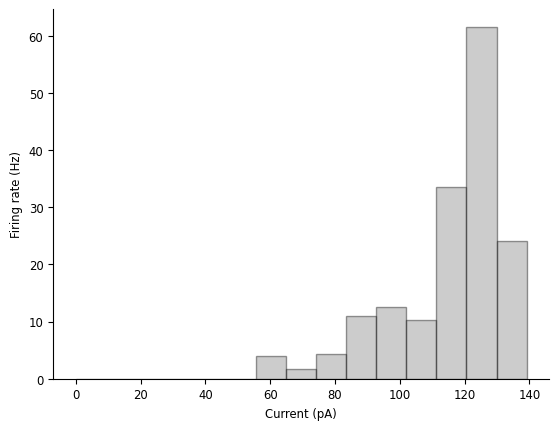

In [20]:
doc_plots.tuning_curve_plot(tuning_curve);

We can see that, while the firing rate mostly increases with the current,
it's definitely not a linear relationship, and it might start decreasing as
the current gets too large.

So this gives us three interesting phenomena we'd like our model to help
explain: 

- the tuning curve between the firing rate and the current.
- the firing rate's periodicity.
- the gradual reduction in firing rate while the current remains on.


## NeMoS 

(current-inj-prep-full)=
### Preparing data

Now that we understand our data, we're almost ready to put the model together.
Before we construct it, however, we need to get the data into the right format.

When fitting a single neuron, NeMoS requires that the predictors and spike
counts it operates on have the following properties:

- predictors and spike counts must have the same number of time points.

- predictors must be two-dimensional, with shape `(n_time_bins, n_features)`.
  In this example, we have a single feature (the injected current).

- spike counts must be one-dimensional, with shape `(n_time_bins, )`. As
  discussed above, `n_time_bins` must be the same for both the predictors and
  spike counts.

- predictors and spike counts must be
  [`jax.numpy`](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html)
  arrays, `numpy` arrays or `pynapple` `TsdFrame`/`Tsd`.

:::{admonition} What is jax?
:class: note

[jax](https://github.com/jax-ml/jax) is a Google-supported python library
for automatic differentiation. It has all sorts of neat features, but the
most relevant of which for NeMoS is its GPU-compatibility and
just-in-time compilation (both of which make code faster with little
overhead!), as well as the collection of optimizers present in
[jaxopt](https://jaxopt.github.io/stable/).
:::

First, we require that our predictors and our spike counts have the same
number of time bins. We can achieve this by down-sampling our current to the
spike counts to the proper resolution using the
[`bin_average`](https://pynapple.org/generated/pynapple.Tsd.bin_average.html)
method from pynapple:

<div class="render-user render-presenter">
Get data from pynapple to NeMoS-ready format:

- predictors and spikes must have same number of time points
</div>

In [21]:
binned_current = current.bin_average(bin_size)

print(f"current shape: {binned_current.shape}")
# rate is in Hz, convert to KHz
print(f"current sampling rate: {binned_current.rate/1000.:.02f} KHz")

print(f"\ncount shape: {count.shape}")
print(f"count sampling rate: {count.rate/1000:.02f} KHz")

current shape: (28020,)
current sampling rate: 1.00 KHz

count shape: (28020,)
count sampling rate: 1.00 KHz


Secondly, we have to reshape our variables so that they are the proper shape:

- `predictors`: `(n_time_bins, n_features)`
- `count`: `(n_time_bins, )`

Because we only have a single predictor feature, we'll use
[`np.expand_dims`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html)
to ensure it is a 2d array.

<div class="render-user render-presenter">
- predictors must be 2d, spikes 1d
</div>

In [22]:
predictor = np.expand_dims(binned_current, 1)

# check that the dimensionality matches NeMoS expectation
print(f"predictor shape: {predictor.shape}")
print(f"count shape: {count.shape}")

predictor shape: (28020, 1)
count shape: (28020,)


:::{admonition} What if I have more than one neuron?
:class: info

In this example, we're only fitting data for a single neuron, but you
might wonder how the data should be shaped if you have more than one
neuron.

NeMoS has a separate
[`PopulationGLM`](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.html#nemos.glm.PopulationGLM)
object for fitting a population of neurons. It operates very similarly to the
`GLM` object we use here: it still expects a 2d input, with neurons concatenated
along the second dimension. (NeMoS provides some helper functions for splitting
the design matrix and model parameter arrays to make them more interpretable.)

Note that, with a generalized linear model, fitting each neuron separately is
equivalent to fitting the entire population at once. Fitting them separately can
make your life easier by e.g., allowing you to parallelize more easily.

:::

(current-inj-glm-full)=
### Fitting the model

Now we're ready to fit our model!

First, we need to define our GLM model object. We intend for users
to interact with our models like
[scikit-learn](https://scikit-learn.org/stable/getting_started.html)
estimators. In a nutshell, a model instance is initialized with
hyperparameters that specify optimization and model details,
and then the user calls the `.fit()` function to fit the model to data.
We will walk you through the process below by example, but if you
are interested in reading more details see the [Getting Started with scikit-learn](https://scikit-learn.org/stable/getting_started.html) webpage.

To initialize our model, we need to specify the solver, the regularizer, and the observation
model. All of these are optional.

- `solver_name`: this string specifies the solver algorithm. The default
  behavior depends on the regularizer, as each regularization scheme is only
  compatible with a subset of possible solvers. View the [GLM
  docstring](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM)
  for more details.

:::{warning}

With a convex problem like the GLM, in theory it does not matter which
solver algorithm you use. In practice, due to numerical issues, it
generally does. Thus, it's worth trying a couple to see how their
solutions compare.
:::

- `regularizer`: this string or object specifies the regularization scheme.
  Regularization modifies the objective function to reflect your prior beliefs
  about the parameters, such as sparsity. Regularization becomes more important
  as the number of input features, and thus model parameters, grows. NeMoS's
  solvers can be found within the [`nemos.regularizer`
  module](https://nemos.readthedocs.io/en/latest/api_reference.html#the-nemos-regularizer-module).
  If you pass a string matching the name of one of our solvers, we initialize
  the solver with the default arguments. If you need more control, you will need
  to initialize and pass the object yourself.

- `observation_model`: this object links the firing rate and the observed data
  (in this case spikes), describing the distribution of neural activity (and
  thus changing the log-likelihood). For spiking data, we use the Poisson
  observation model, but we discuss other options for continuous data in our
  [documentation](https://nemos.readthedocs.io/en/latest/tutorials/plot_06_calcium_imaging.html).

For this example, we'll use an un-regularized LBFGS solver. We'll discuss
regularization in a later tutorial.

:::{admonition} Why LBFGS?
:class: info

[LBFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) is a
quasi-Netwon method, that is, it uses the first derivative (the gradient)
and approximates the second derivative (the Hessian) in order to solve
the problem. This means that LBFGS tends to find a solution faster and is
often less sensitive to step-size. Try other solvers to see how they
behave!
:::

<div class="render-user render-presenter">
- GLM objects need regularizers and observation models
</div>

In [23]:
# Initialize the model, specifying the solver. we'll accept the defaults
# for everything else.
model = nmo.glm.GLM(solver_name="LBFGS")

Now that we've initialized our model with the optimization parameters, we can
fit our data! In the previous section, we prepared our model matrix
(`predictor`) and target data (`count`), so to fit the model we just need to
pass them to the model:

<div class="render-user render-presenter">
- call fit and retrieve parameters
</div>

In [24]:
model.fit(predictor, count)

,observation_model,PoissonObservations()
,inverse_link_function,<PjitFunction...7f6e19b4cd60>>
,regularizer,UnRegularized()
,regularizer_strength,None
,solver_name,'LBFGS'
,solver_kwargs,{}


Now that we've fit our data, we can retrieve the resulting parameters.
Similar to scikit-learn, these are stored as the `coef_` and `intercept_`
attributes:

In [25]:
print(f"firing_rate(t) = exp({model.coef_} * current(t) + {model.intercept_})")

firing_rate(t) = exp([0.05330395] * current(t) + [-9.761153])


Note that `model.coef_` has shape `(n_features, )`, while `model.intercept_` has
shape `(n_neurons)` (for the `GLM` object, this will always be 1, but it will
differ for the `PopulationGLM` object!):

In [26]:
print(f"coef_ shape: {model.coef_.shape}")
print(f"intercept_ shape: {model.intercept_.shape}")

coef_ shape: (1,)
intercept_ shape: (1,)


It's nice to get the parameters above, but we can't tell how well our model
is doing by looking at them. So how should we evaluate our model?

First, we can use the model to predict the firing rates and compare that to the
smoothed spike train. By calling
[`predict()`](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.predict.html)
we can get the model's predicted firing rate for this data. Note that this is
just the output of the model's linear-nonlinear step, as described earlier!

<div class="render-user render-presenter">
- generate model predictions.
</div>

In [27]:
predicted_fr = model.predict(predictor)
# convert units from spikes/bin to spikes/sec
predicted_fr = predicted_fr / bin_size


# and let's smooth the firing rate the same way that we smoothed the firing rate
smooth_predicted_fr = predicted_fr.smooth(0.05, size_factor=20)

<div class="render-user render-presenter">
- and visualize!
</div>

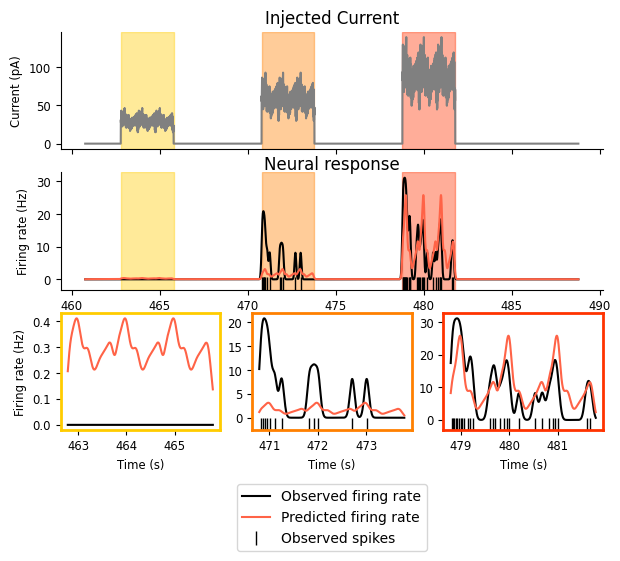

In [28]:
# and plot!
fig = doc_plots.current_injection_plot(current, spikes, firing_rate,
                                 # plot the predicted firing rate that has
                                 # been smoothed the same way as the
                                 # smoothed spike train
                                 predicted_firing_rates=smooth_predicted_fr)

What do we see above? Note that the y-axes in the final row are different for
each subplot!

- Predicted firing rate increases as injected current goes up &mdash; Success! &#x1F389;

- The amplitude of the predicted firing rate only matches the observed
  amplitude in the third interval: it's too high in the first and too low in
  the second &mdash; Failure! &#x274C;

- Our predicted firing rate has the periodicity we see in the smoothed spike
  train &mdash; Success! &#x1F389;

- The predicted firing rate does not decay as the input remains on: the
  amplitudes are identical for each of the bumps within a given interval &mdash;
  Failure! &#x274C;

The failure described in the second point may seem particularly confusing &mdash;
approximate amplitude feels like it should be very easy to capture, so what's
going on?

To get a better sense, let's look at the mean firing rate over the whole
period:

<div class="render-user render-presenter">
- what do we see?
</div>

In [29]:
# compare observed mean firing rate with the model predicted one
print(f"Observed mean firing rate: {np.mean(firing_rate)} Hz")
print(f"Predicted mean firing rate: {np.mean(predicted_fr)} Hz")

Observed mean firing rate: 1.4275517487508922 Hz
Predicted mean firing rate: 1.4306572675704956 Hz


We matched the average pretty well! So we've matched the average and the
range of inputs from the third interval reasonably well, but overshot at low
inputs and undershot in the middle.

We can see this more directly by computing the tuning curve for our predicted
firing rate and comparing that against our smoothed spike train from the
beginning of this notebook. Pynapple can help us again with this:

<div class="render-user render-presenter">
- examine tuning curve &mdash; what do we see?
</div>

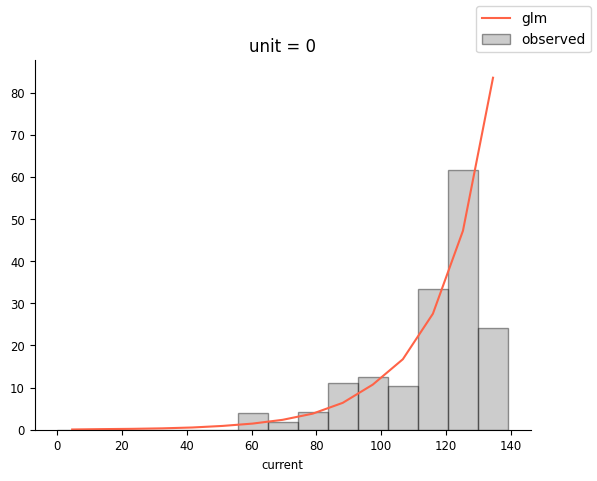

In [30]:
tuning_curve_model = nap.compute_tuning_curves(predicted_fr, current, bins=15, feature_names=["current"])
fig = doc_plots.tuning_curve_plot(tuning_curve)
tuning_curve_model.plot(color="tomato", label="glm")
fig.legend()

In addition to making that mismatch discussed earlier a little more obvious,
this tuning curve comparison also highlights that this model thinks the
firing rate will continue to grow as the injected current increases, which is
not reflected in the data (or in our knowledge of how neurons work!).

Viewing this plot also makes it clear that the model's tuning curve is
approximately exponential. We already knew that! That's what it means to be a
LNP model of a single input. But it's nice to see it made explicit.

(current-inj-basis-full)=
### Extending the model to use injection history

We can try extending the model in order to improve its performance. There are many
ways one can do this: the iterative refinement and improvement of your model is an
important part of the scientific process! In this tutorial, we'll discuss one such
extension, but you're encouraged to try others.

Our model right now assumes that the neuron's spiking behavior is only driven by the
*instantaneous input current*. That is, we're saying that history doesn't matter. But
we know that neurons integrate information over time, so why don't we add extend our
model to reflect that?

To do so, we will change our predictors, including variables that represent the
history of the input current as additional columns. First, we must decide the
duration of time that we think is relevant: does current passed to the cell 10
msec ago matter? what about 100 msec? 1 sec? To start, we should use our a
priori knowledge about the system to determine a reasonable initial value. In
later notebooks, we'll learn how to use NeMoS with scikit-learn to do formal
model comparison in order to determine how much history is necessary.

For now, let's use a duration of 200 msec:

<div class="render-user render-presenter">
  - choose a length of time over which the neuron integrates the input current
</div>

In [31]:
current_history_duration_sec = .2
# convert this from sec to bins
current_history_duration = int(current_history_duration_sec / bin_size)

To construct our new predictors, we could simply take the current and shift it
incrementally. The value of predictor `binned_current` at time $t$ is the injected
current at time $t$; by shifting `binned_current` backwards by 1, we are modeling the
effect of the current at time $t-1$ on the firing rate at time $t$, and so on for all
shifts $i$ up to `current_history_duration`:

In [32]:
binned_current[1:]
binned_current[2:]
# etc

Time (s)
----------  --
460.7705     0
460.7715     0
460.7725     0
460.7735     0
460.7745     0
460.7755     0
460.7765     0
...
488.7815     0
488.7825     0
488.7835     0
488.7845     0
488.7855     0
488.7865     0
488.7875     0
dtype: float64, shape: (28018,)

In general, however, this is not a good way to extend the model in the way discussed.
You will end end up with a very large number of predictive variables (one for every
bin shift!), which will make the model more sensitive to noise in the data.

A better idea is to do some dimensionality reduction on these predictors, by
parametrizing them using **basis functions**. These will allow us to capture
interesting non-linear effects with a relatively low-dimensional parametrization
that preserves convexity. NeMoS has a whole library of basis objects available
at
[`nmo.basis`](https://nemos.readthedocs.io/en/latest/background/basis/README.html),
and choosing which set of basis functions and their parameters, like choosing
the duration of the current history predictor, requires knowledge of your
problem, but can later be examined using model comparison tools.

For history-type inputs like we're discussing, the raised cosine log-stretched basis
first described in Pillow et al., 2005 [^pillow] is a good fit. This basis set has the nice
property that their precision drops linearly with distance from event, which is a
makes sense for many history-related inputs in neuroscience: whether an input happened
1 or 5 msec ago matters a lot, whereas whether an input happened 51 or 55 msec ago is
less important.

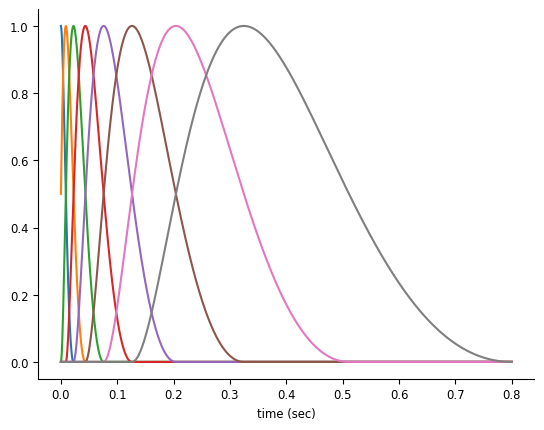

In [33]:
doc_plots.plot_basis();

[^pillow]: Pillow, J. W., Paninski, L., Uzzel, V. J., Simoncelli, E. P., & J.,
C. E. (2005). Prediction and decoding of retinal ganglion cell responses
with a probabilistic spiking model. Journal of Neuroscience, 25(47),
11003–11013. http://dx.doi.org/10.1523/jneurosci.3305-05.2005

NeMoS's `Basis` objects handle the construction and use of these basis functions. When
we instantiate this object, the main argument we need to specify is the number of
functions we want: with more basis functions, we'll be able to represent the effect of
the corresponding input with the higher precision, at the cost of adding additional
parameters.

We also need to specify whether we want to use the convolutional (`Conv`) or
evaluation (`Eval`) form of the basis. This is determined by the type of feature
we wish to represent with the basis:

- Evaluation bases transform the input through the non-linear function defined
  by the basis. This can be used to represent features such as spatial location
  and head direction.

- Convolution bases apply a convolution of the input data to the bank of filters
  defined by the basis, and is particularly useful when analyzing data with
  inherent temporal dependencies, such as spike history or the history of input
  current in this example. In convolution mode, we must additionally specify the
  `window_size`, the length of the filters in bins.

<div class="render-user render-presenter">
  - define a basis object
</div>

In [34]:
basis = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=current_history_duration,
)

:::{admonition} Visualizing `Basis` objects
:class: tip

NeMoS provides some convenience functions for quickly visualizing the basis, in
order to create plots like the type seen above.

```python
# basis_kernels is an array of shape (current_history_duration, n_basis_funcs)
# while time is an array of shape (current_history_duration, )
time, basis_kernels = basis.evaluate_on_grid(current_history_duration)
# convert time to sec
time *= current_history_duration_sec
plt.plot(time, basis_kernels)
```

:::

With this basis in hand, we can compress our input features:

<div class="render-user render-presenter">
  - create the design matrix
  - examine the features it contains
</div>

In [35]:
# under the hood, this convolves the input with the filter bank visualized above
current_history = basis.compute_features(binned_current)
print(current_history)

Time (s)      0    1    2    3    4  ...
----------  ---  ---  ---  ---  ---  -----
460.7685    nan  nan  nan  nan  nan  ...
460.7695    nan  nan  nan  nan  nan  ...
460.7705    nan  nan  nan  nan  nan  ...
460.7715    nan  nan  nan  nan  nan  ...
460.7725    nan  nan  nan  nan  nan  ...
460.7735    nan  nan  nan  nan  nan  ...
460.7745    nan  nan  nan  nan  nan  ...
...                                  ...
488.7815      0    0    0    0    0  ...
488.7825      0    0    0    0    0  ...
488.7835      0    0    0    0    0  ...
488.7845      0    0    0    0    0  ...
488.7855      0    0    0    0    0  ...
488.7865      0    0    0    0    0  ...
488.7875      0    0    0    0    0  ...
dtype: float32, shape: (28020, 8)


We can see that our design matrix is now 28020 time points by 8 features, one for
each of our basis functions. If we had used the raw shifted data as the features, like
we started to do above, we'd have a design matrix with 200 features, so we've ended up
with more than an order of magnitude fewer features!

Note that we have a bunch of NaNs at the beginning of each column. That's because of
boundary handling: we're using the input of the past 200 msecs to predict the firing
rate at time $t$, so what do we do in the first 200 msecs? The safest way is to ignore
them, so that the model doesn't consider them during the fitting procedure.

What do these features look like?

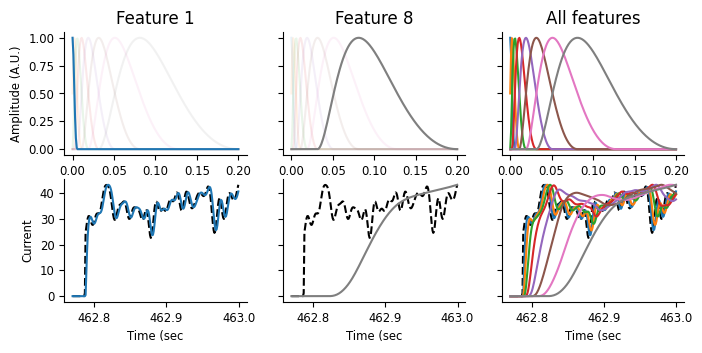

In [36]:
# in this plot, we're normalizing the amplitudes to make the comparison easier --
# the amplitude of these features will be fit by the model, so their un-scaled
# amplitudes is not informative
workshop_utils.plot_current_history_features(binned_current, current_history, basis,
                                             current_history_duration_sec)

On the top row, we're visualizing the basis functions, as above. On the bottom row,
we're showing the input current, as a black dashed line, and corresponding features
over a small window of time, just as the current is being turned on. These features
are the result of a convolution between the basis function on the top row with the
black dashed line shown below. As the basis functions get progressively wider and
delayed from the event start, we can thus think of the features as weighted averages
that get progressively later and smoother. Let's step through that a bit more slowly.

In the leftmost plot, we can see that the first feature almost perfectly tracks the
input. Looking at the basis function above, that makes sense: this function's max is
at 0 and quickly decays. This feature is thus a very slightly smoothed version of the
instantaneous current feature we were using before. In the middle plot, we can see
that the last feature has a fairly long lag compared to the current, and is a good
deal smoother. Looking at the rightmost plot, we can see that the other features vary
between these two extremes, getting smoother and more delayed.

These are the elements of our feature matrix: representations of not just the
instantaneous current, but also the current history, with precision decreasing as the
lag between the predictor and current increases. Let's see what this looks like when
we go to fit the model!

We'll initialize and create the GLM object in the same way as before, only changing
the design matrix we pass to the model:

<div class="render-user render-presenter">
  - create and fit the GLM
  - examine the parameters
</div>

In [37]:
history_model = nmo.glm.GLM(solver_name="LBFGS")
history_model.fit(current_history, count)

,observation_model,PoissonObservations()
,inverse_link_function,<PjitFunction...7f6e19b4cd60>>
,regularizer,UnRegularized()
,regularizer_strength,None
,solver_name,'LBFGS'
,solver_kwargs,{}


As before, we can examine our parameters, `coef_` and `intercept_`:

In [38]:
print(f"firing_rate(t) = exp({history_model.coef_} * current(t) + {history_model.intercept_})")

firing_rate(t) = exp([-1.0739113e-02  2.6212724e-02 -1.3185825e-02  1.3647630e-02
 -9.2323860e-03  2.5391979e-03  7.3373754e-05 -3.6567418e-04] * current(t) + [-9.896181])


Notice the shape of these parameters:

In [39]:
print(history_model.coef_.shape)
print(history_model.intercept_.shape)

(8,)
(1,)


`coef_` has 8 values now, while `intercept_` still has one &mdash; why is that?
Because we now have 8 features, but still only 1 neuron whose firing rate we're
predicting.

In addition to visualizing the model's predictions (which we'll do in a second),
we can also examine the model's learned filter. Our earlier model was just
learning a simple function linking the input current and the firing rate, but
this model learns a filter, which gets convolved with the input before having
the intercept added and being exponentiated to give us the predicted firing
rate.

<div class="render-user render-presenter">

(visualize-filter-full)=
- Visualize the current history model's learned filter.
- This filter is convolved with the input current and used to predict the firing
  rate.

</div>

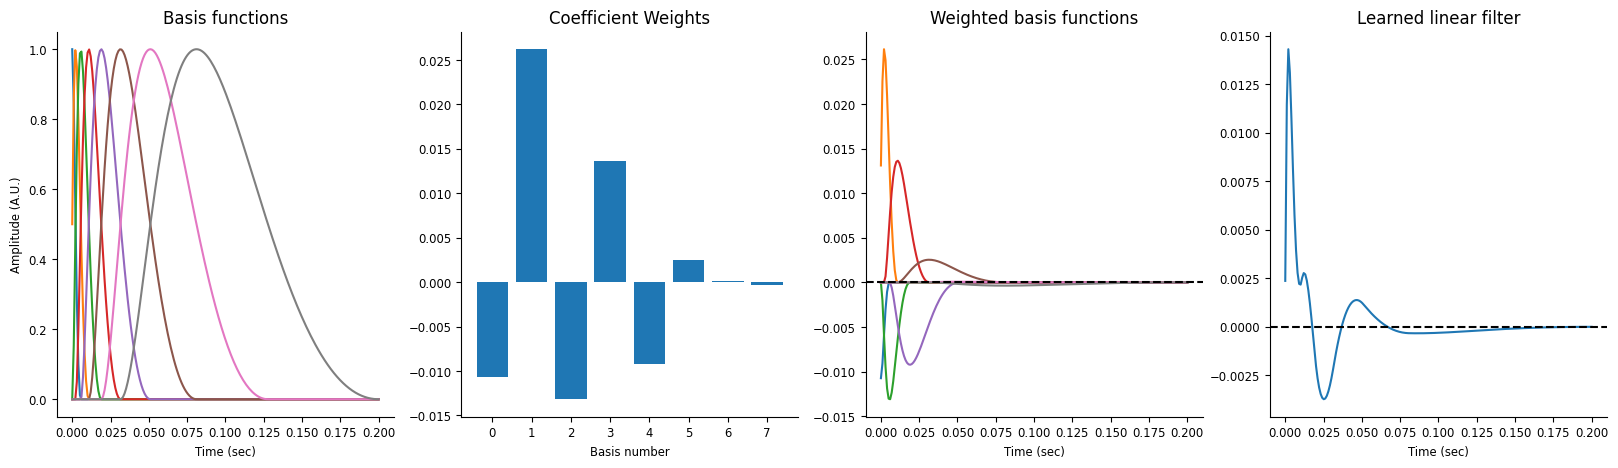

In [40]:
workshop_utils.plot_basis_filter(basis, history_model)

Let's re-examine our predicted firing rate and see how the new model does:

<div class="render-user render-presenter">

  - compare the predicted firing rate to the data and the old model
  - what do we see?
</div>

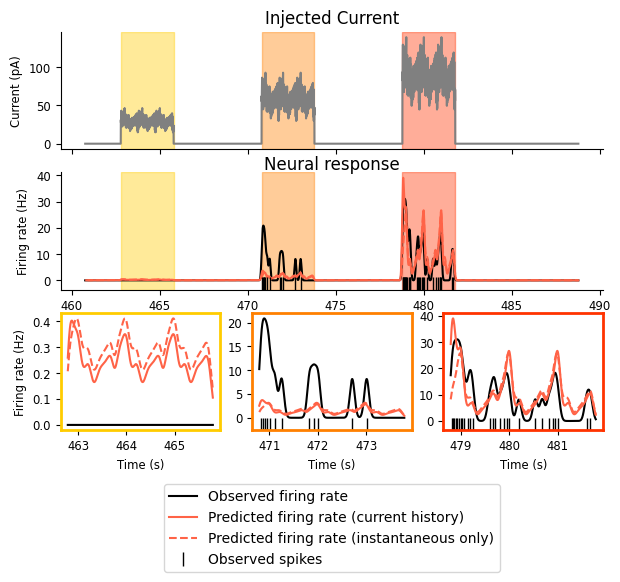

In [41]:
# all this code is the same as above
history_pred_fr = history_model.predict(current_history)
history_pred_fr = history_pred_fr / bin_size
smooth_history_pred_fr = history_pred_fr.dropna().smooth(.05, size_factor=20)
workshop_utils.current_injection_plot(current, spikes, firing_rate,
                                      # compare against the old firing rate
                                      smooth_history_pred_fr, smooth_predicted_fr)

We can see that there are only some small changes here. Our new model maintains the
two successes of the old one: firing rate increases with injected current and shows
the observed periodicity. Our model has not improved the match between the firing rate
in the first or second intervals, but it seems to do a better job of capturing the
onset transience, especially in the third interval.

We can similarly examine our mean firing rate:

<div class="render-user render-presenter">
  - examine the predicted average firing rate and tuning curve
  - what do we see?
</div>

In [42]:
# compare observed mean firing rate with the history_model predicted one
print(f"Observed mean firing rate: {np.mean(count) / bin_size} Hz")
print(f"Predicted mean firing rate (instantaneous current): {np.nanmean(predicted_fr)} Hz")
print(f"Predicted mean firing rate (current history): {np.nanmean(smooth_history_pred_fr)} Hz")

Observed mean firing rate: 1.4275517487508922 Hz
Predicted mean firing rate (instantaneous current): 1.4306572675704956 Hz
Predicted mean firing rate (current history): 1.4376871215756206 Hz


And our tuning curves:

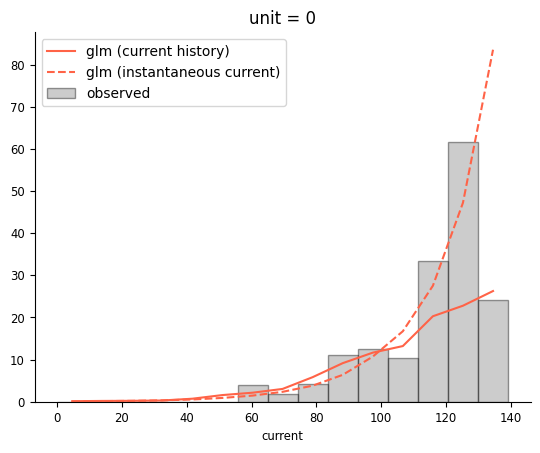

In [43]:
# Visualize tuning curve
tuning_curve_history_model = nap.compute_tuning_curves(smooth_history_pred_fr, current, bins=15, feature_names=["current"])
fig = doc_plots.tuning_curve_plot(tuning_curve)
tuning_curve_history_model.plot(color="tomato", label="glm (current history)")
tuning_curve_model.plot(color="tomato", linestyle='--', label="glm (instantaneous current)")
fig.axes[0].legend()

This new model is doing a comparable job matching the mean firing rate. Looking
at the tuning curve, it looks like this model does a better job at a lot of
firing rate levels, but its maximum firing rate is far too low and it's not
clear if the tuning curve has leveled off.

Comparing the two models by examining their predictions is important, but you may also
want a number with which to evaluate and compare your models' performance. As
discussed earlier, the GLM optimizes log-likelihood to find the best-fitting
weights, and we can calculate this number using its `score` method:

<div class="render-user render-presenter">
  - use log-likelihood to compare models
</div>

In [44]:
log_likelihood = model.score(predictor, count, score_type="log-likelihood")
print(f"log-likelihood (instantaneous current): {log_likelihood}")
log_likelihood = history_model.score(current_history, count, score_type="log-likelihood")
print(f"log-likelihood (current history): {log_likelihood}")

log-likelihood (instantaneous current): -0.00793992169201374


log-likelihood (current history): -0.007489887997508049


This log-likelihood is un-normalized and thus doesn't mean that much by
itself, other than "higher=better". When comparing alternative GLMs fit on
the same dataset, whether that's models using different regularizers and
solvers or those using different predictors, comparing log-likelihoods is a
reasonable thing to do.

:::{note}

Under the hood, NeMoS is minimizing the negative log-likelihood, as is
typical in many optimization contexts. `score` returns the real
log-likelihood, however, and thus higher is better.

:::

Thus, we can see that, judging by the log-likelihood, the addition of the
current history to the model makes the model slightly better. We have also
increased the number of parameters, which can make you more susceptible to
overfitting and so, while the difference is small here, it's possible that
including the extra parameters has made us more sensitive to noise. To properly
investigate whether that's the case, one should split the dataset into test and
train sets, training the model on one subset of the data and testing it on
another to test the model's generalizability. We'll see a version of this
using `scikit-learn`'s pipelining and cross-validation machinery, will be shown
in the [NeMoS Advanced notebook](sklearn-nb-full).

(current-inj-score-full)=
### Finishing up

Note that, because the log-likelihood is un-normalized, it should not be compared
across datasets (because e.g., it won't account for difference in noise levels). We
provide the ability to compute the pseudo-$R^2$ for this purpose:

<div class="render-user render-presenter">
  - what if you want to compare models across datasets?
</div>

In [45]:
r2 = model.score(predictor, count, score_type='pseudo-r2-Cohen')
print(f"pseudo-r2 (instantaneous current): {r2}")
r2 = history_model.score(current_history, count, score_type='pseudo-r2-Cohen')
print(f"pseudo-r2 (current history): {r2}")

pseudo-r2 (instantaneous current): 0.30376628041267395
pseudo-r2 (current history): 0.35689446330070496


## Further Exercises 

Despite the simplicity of this dataset, there is still more that we can do
here. The following sections provide some possible exercises to try yourself!

<div class="render-user render-presenter">
- what else can we do?
</div>

**Other stimulation protocols**

We've only fit the model to a single stimulation protocol, but our dataset
contains many more! How does the model perform on "Ramp"? On "Noise 2"? Based
on the example code above, write new code that fits the model on some other
stimulation protocol and evaluate its performance. Which stimulation does it
perform best on? Which is the worst?

**Train and test sets**

In this example, we've used been fitting and evaluating our model on the same
data set. That's generally a bad idea! Try splitting the data in to train and
test sets, fitting the model to one portion of the data and evaluating on
another portion. You could split this stimulation protocol into train and
test sets or use different protocols to train and test on.

**Model extensions**

Our model did not do a good job capturing the onset transience seen in the
data, and we could probably improve the match between the amplitudes of the
predicted firing rate and smoothed spike train. How would we do that?

We could try adding the following inputs to the model, alone or together:

- Tinkering with the current history: we tried adding the current history to the
  model, but we only investigated one set of choices with the basis functions. What if
  we tried changing the duration of time we considered
  (`current_history_duration_sec`)? Different numbers of basis functions? A different
  choice for the `Basis` object altogether? What effects would these have on our model?

- Spiking history: we know neurons have a refactory period (they are unable to spike a
  second time immediately after spiking), so maybe making the model aware of whether
  the neuron spiked recently could help better capture the onset transience.

- More complicated tuning curve: as we saw with the tuning curve plots, neither
  model explored here quite accurately captures the relationship between the
  current and the firing rate. Can we improve that somehow? We saw that adding
  the current history changed this relationship, but we can also change it
  without including the history by using an `Eval` basis object. We'll see how
  to do this in more detail in the [final notebook](sklearn-basis-full)

<div class="render-all">

### Data citation

The data used in this tutorial is from the **Allen Brain Map**, with the [following citation](https://knowledge.brain-map.org/data/1HEYEW7GMUKWIQW37BO/summary):

**Contributors:** Agata Budzillo, Bosiljka Tasic, Brian R. Lee, Fahimeh Baftizadeh, Gabe Murphy, Hongkui Zeng, Jim Berg, Nathan Gouwens, Rachel Dalley, Staci A. Sorensen, Tim Jarsky, Uygar Sümbül Zizhen Yao

**Dataset:** Allen Institute for Brain Science (2020). Allen Cell Types Database -- Mouse Patch-seq [dataset]. Available from brain-map.org/explore/classes/multimodal-characterization.

**Primary publication:** Gouwens, N.W., Sorensen, S.A., et al. (2020). Integrated morphoelectric and transcriptomic classification of cortical GABAergic cells. Cell, 183(4), 935-953.E19. https://doi.org/10.1016/j.cell.2020.09.057

**Patch-seq protocol:** Lee, B. R., Budzillo, A., et al. (2021). Scaled, high fidelity electrophysiological, morphological, and transcriptomic cell characterization. eLife, 2021;10:e65482. https://doi.org/10.7554/eLife.65482

**Mouse VISp L2/3 glutamatergic neurons:** Berg, J., Sorensen, S. A., Miller, J., Ting, J., et al. (2021) Human neocortical expansion involves glutamatergic neuron diversification. Nature, 598(7879):151-158. doi: 10.1038/s41586-021-03813-8

</div>